# Setup Environment (Colab)

In [1]:
# Install required libraries
!pip install opencv-python-headless kaggle


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Download FER2013 Dataset (Kaggle)

In [5]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rigel07","key":"d9b570c3043f6a5d5f3daf729c40dcd0"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

# View Sample Images

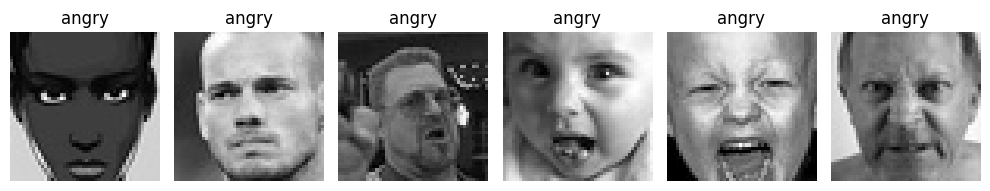

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import random

data_dir = "train"   # or "test"
emotion = random.choice(os.listdir(data_dir))
emotion_path = os.path.join(data_dir, emotion)

images = random.sample(os.listdir(emotion_path), 6)

plt.figure(figsize=(10,4))

for i, img_name in enumerate(images):
    img_path = os.path.join(emotion_path, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(1,6,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing & Augmentation

In [8]:
IMG_SIZE = 48
BATCH_SIZE = 64


In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)


test_datagen = ImageDataGenerator(rescale=1./255)


In [22]:
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model Architecture

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    Flatten, BatchNormalization
)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.30))

# Block 3
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.35))

# Dense Head
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))


In [24]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

# Train the Model

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6, min_lr=1e-6),
    ModelCheckpoint(
        "best_emotion_model.h5",
        monitor='val_accuracy',
        save_best_only=True
    )
]


In [27]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=80,
    callbacks=callbacks
)



Epoch 1/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1713 - loss: 2.8881

449/449 ━━━━━━━━━━━━━━━━━━━━ 62s 106ms/step - accuracy: 0.1714 - loss: 2.8877 - val_accuracy: 0.2544 - val_loss: 1.9287 - learning_rate: 1.0000e-04
Epoch 2/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2089 - loss: 2.3293

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.2089 - loss: 2.3292 - val_accuracy: 0.3318 - val_loss: 1.7768 - learning_rate: 1.0000e-04
Epoch 3/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2296 - loss: 2.1866

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.2296 - loss: 2.1866 - val_accuracy: 0.3320 - val_loss: 1.6855 - learning_rate: 1.0000e-04
Epoch 4/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2478 - loss: 2.0881

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.2478 - loss: 2.0881 - val_accuracy: 0.3406 - val_loss: 1.6639 - learning_rate: 1.0000e-04
Epoch 5/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2648 - loss: 2.0142

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.2648 - loss: 2.0141 - val_accuracy: 0.3955 - val_loss: 1.5549 - learning_rate: 1.0000e-04
Epoch 6/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2827 - loss: 1.9483

449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - accuracy: 0.2827 - loss: 1.9482 - val_accuracy: 0.4230 - val_loss: 1.4980 - learning_rate: 1.0000e-04
Epoch 7/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3080 - loss: 1.8740

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.3080 - loss: 1.8740 - val_accuracy: 0.4276 - val_loss: 1.4948 - learning_rate: 1.0000e-04
Epoch 8/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3312 - loss: 1.8075

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.3313 - loss: 1.8074 - val_accuracy: 0.4468 - val_loss: 1.4463 - learning_rate: 1.0000e-04
Epoch 9/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3509 - loss: 1.7420

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.3509 - loss: 1.7420 - val_accuracy: 0.4660 - val_loss: 1.4378 - learning_rate: 1.0000e-04
Epoch 10/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3804 - loss: 1.6548

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.3804 - loss: 1.6548 - val_accuracy: 0.4900 - val_loss: 1.3530 - learning_rate: 1.0000e-04
Epoch 11/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3976 - loss: 1.6142

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.3976 - loss: 1.6142 - val_accuracy: 0.4935 - val_loss: 1.4151 - learning_rate: 1.0000e-04
Epoch 12/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4196 - loss: 1.5486

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.4196 - loss: 1.5486 - val_accuracy: 0.5219 - val_loss: 1.2725 - learning_rate: 1.0000e-04
Epoch 13/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4315 - loss: 1.5060

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.4315 - loss: 1.5059 - val_accuracy: 0.5265 - val_loss: 1.2615 - learning_rate: 1.0000e-04
Epoch 14/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4497 - loss: 1.4563

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.4497 - loss: 1.4563 - val_accuracy: 0.5284 - val_loss: 1.2514 - learning_rate: 1.0000e-04
Epoch 15/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4655 - loss: 1.4072

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.4655 - loss: 1.4072 - val_accuracy: 0.5397 - val_loss: 1.2107 - learning_rate: 1.0000e-04
Epoch 16/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4751 - loss: 1.3841

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.4751 - loss: 1.3841 - val_accuracy: 0.5564 - val_loss: 1.1739 - learning_rate: 1.0000e-04
Epoch 17/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.4853 - loss: 1.3565 - val_accuracy: 0.5563 - val_loss: 1.1686 - learning_rate: 1.0000e-04
Epoch 18/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.4925 - loss: 1.3279 - val_accuracy: 0.5541 - val_loss: 1.1863 - learning_rate: 1.0000e-04
Epoch 19/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5021 - loss: 1.2983

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5021 - loss: 1.2983 - val_accuracy: 0.5619 - val_loss: 1.1637 - learning_rate: 1.0000e-04
Epoch 20/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5195 - loss: 1.2635

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5195 - loss: 1.2635 - val_accuracy: 0.5695 - val_loss: 1.1318 - learning_rate: 1.0000e-04
Epoch 21/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5225 - loss: 1.2652

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.5225 - loss: 1.2652 - val_accuracy: 0.5756 - val_loss: 1.1176 - learning_rate: 1.0000e-04
Epoch 22/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5270 - loss: 1.2446 - val_accuracy: 0.5663 - val_loss: 1.1430 - learning_rate: 1.0000e-04
Epoch 23/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5316 - loss: 1.2258

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5316 - loss: 1.2258 - val_accuracy: 0.5872 - val_loss: 1.0894 - learning_rate: 1.0000e-04
Epoch 24/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5405 - loss: 1.2044 - val_accuracy: 0.5797 - val_loss: 1.1104 - learning_rate: 1.0000e-04
Epoch 25/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5445 - loss: 1.1995

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.5445 - loss: 1.1995 - val_accuracy: 0.5931 - val_loss: 1.0649 - learning_rate: 1.0000e-04
Epoch 26/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5472 - loss: 1.1896

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.5472 - loss: 1.1896 - val_accuracy: 0.6010 - val_loss: 1.0589 - learning_rate: 1.0000e-04
Epoch 27/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5509 - loss: 1.1801 - val_accuracy: 0.5889 - val_loss: 1.0775 - learning_rate: 1.0000e-04
Epoch 28/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5595 - loss: 1.1674 - val_accuracy: 0.5942 - val_loss: 1.0690 - learning_rate: 1.0000e-04
Epoch 29/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5720 - loss: 1.1360

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.5720 - loss: 1.1360 - val_accuracy: 0.6023 - val_loss: 1.0551 - learning_rate: 1.0000e-04
Epoch 30/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.5562 - loss: 1.1547 - val_accuracy: 0.5967 - val_loss: 1.0596 - learning_rate: 1.0000e-04
Epoch 31/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5640 - loss: 1.1348

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.5640 - loss: 1.1348 - val_accuracy: 0.6052 - val_loss: 1.0475 - learning_rate: 1.0000e-04
Epoch 32/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5724 - loss: 1.1351

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5724 - loss: 1.1351 - val_accuracy: 0.6088 - val_loss: 1.0437 - learning_rate: 1.0000e-04
Epoch 33/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.5782 - loss: 1.1152 - val_accuracy: 0.6003 - val_loss: 1.0557 - learning_rate: 1.0000e-04
Epoch 34/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5832 - loss: 1.1114 - val_accuracy: 0.6059 - val_loss: 1.0456 - learning_rate: 1.0000e-04
Epoch 35/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5772 - loss: 1.1140 - val_accuracy: 0.6050 - val_loss: 1.0391 - learning_rate: 1.0000e-04
Epoch 36/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5805 - loss: 1.1042

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5805 - loss: 1.1042 - val_accuracy: 0.6105 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 37/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5820 - loss: 1.1047

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5820 - loss: 1.1047 - val_accuracy: 0.6142 - val_loss: 1.0206 - learning_rate: 1.0000e-04
Epoch 38/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.5874 - loss: 1.0851 - val_accuracy: 0.6030 - val_loss: 1.0595 - learning_rate: 1.0000e-04
Epoch 39/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.5961 - loss: 1.0744 - val_accuracy: 0.6109 - val_loss: 1.0213 - learning_rate: 1.0000e-04
Epoch 40/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5915 - loss: 1.0767

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5915 - loss: 1.0767 - val_accuracy: 0.6254 - val_loss: 1.0033 - learning_rate: 1.0000e-04
Epoch 41/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6010 - loss: 1.0603 - val_accuracy: 0.6194 - val_loss: 1.0012 - learning_rate: 1.0000e-04
Epoch 42/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5971 - loss: 1.0634

449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.5971 - loss: 1.0634 - val_accuracy: 0.6304 - val_loss: 0.9878 - learning_rate: 1.0000e-04
Epoch 43/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5975 - loss: 1.0571 - val_accuracy: 0.6191 - val_loss: 1.0328 - learning_rate: 1.0000e-04
Epoch 44/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5996 - loss: 1.0669

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.5996 - loss: 1.0668 - val_accuracy: 0.6315 - val_loss: 0.9883 - learning_rate: 1.0000e-04
Epoch 45/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6064 - loss: 1.0425 - val_accuracy: 0.6135 - val_loss: 1.0394 - learning_rate: 1.0000e-04
Epoch 46/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6025 - loss: 1.0466

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6025 - loss: 1.0466 - val_accuracy: 0.6328 - val_loss: 0.9950 - learning_rate: 1.0000e-04
Epoch 47/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6142 - loss: 1.0329 - val_accuracy: 0.6123 - val_loss: 1.0422 - learning_rate: 1.0000e-04
Epoch 48/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6087 - loss: 1.0343

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6087 - loss: 1.0343 - val_accuracy: 0.6413 - val_loss: 0.9684 - learning_rate: 1.0000e-04
Epoch 49/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.6132 - loss: 1.0333 - val_accuracy: 0.6294 - val_loss: 0.9981 - learning_rate: 1.0000e-04
Epoch 50/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.6096 - loss: 1.0373 - val_accuracy: 0.6379 - val_loss: 0.9720 - learning_rate: 1.0000e-04
Epoch 51/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.6165 - loss: 1.0241 - val_accuracy: 0.6251 - val_loss: 1.0045 - learning_rate: 1.0000e-04
Epoch 52/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6149 - loss: 1.0268 - val_accuracy: 0.6351 - val_loss: 0.9762 - learning_rate: 1.0000e-04
Epoch 53/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6160 - loss: 1.0192 - val_accuracy: 0.6296 - val_loss: 0.9932 - learning_rate: 1.0000e-04
Epoch 54/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - a

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.6284 - loss: 0.9904 - val_accuracy: 0.6443 - val_loss: 0.9475 - learning_rate: 3.0000e-05
Epoch 60/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 79ms/step - accuracy: 0.6349 - loss: 0.9828 - val_accuracy: 0.6434 - val_loss: 0.9587 - learning_rate: 3.0000e-05
Epoch 61/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6343 - loss: 0.9758 - val_accuracy: 0.6428 - val_loss: 0.9563 - learning_rate: 3.0000e-05
Epoch 62/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6330 - loss: 0.9695

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6330 - loss: 0.9695 - val_accuracy: 0.6471 - val_loss: 0.9482 - learning_rate: 3.0000e-05
Epoch 63/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6308 - loss: 0.9778

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6308 - loss: 0.9778 - val_accuracy: 0.6478 - val_loss: 0.9488 - learning_rate: 3.0000e-05
Epoch 64/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6362 - loss: 0.9704 - val_accuracy: 0.6434 - val_loss: 0.9517 - learning_rate: 3.0000e-05
Epoch 65/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6409 - loss: 0.9573

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6409 - loss: 0.9573 - val_accuracy: 0.6500 - val_loss: 0.9446 - learning_rate: 3.0000e-05
Epoch 66/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6369 - loss: 0.9641

449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.6369 - loss: 0.9641 - val_accuracy: 0.6507 - val_loss: 0.9471 - learning_rate: 3.0000e-05
Epoch 67/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6349 - loss: 0.9726 - val_accuracy: 0.6459 - val_loss: 0.9500 - learning_rate: 3.0000e-05
Epoch 68/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6360 - loss: 0.9640 - val_accuracy: 0.6475 - val_loss: 0.9518 - learning_rate: 3.0000e-05
Epoch 69/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6452 - loss: 0.9537 - val_accuracy: 0.6488 - val_loss: 0.9479 - learning_rate: 3.0000e-05
Epoch 70/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6411 - loss: 0.9625

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - accuracy: 0.6411 - loss: 0.9625 - val_accuracy: 0.6528 - val_loss: 0.9398 - learning_rate: 3.0000e-05
Epoch 71/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6418 - loss: 0.9626 - val_accuracy: 0.6509 - val_loss: 0.9438 - learning_rate: 3.0000e-05
Epoch 72/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.6440 - loss: 0.9534 - val_accuracy: 0.6498 - val_loss: 0.9437 - learning_rate: 3.0000e-05
Epoch 73/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - accuracy: 0.6407 - loss: 0.9559 - val_accuracy: 0.6499 - val_loss: 0.9382 - learning_rate: 3.0000e-05
Epoch 74/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.6436 - loss: 0.9512 - val_accuracy: 0.6513 - val_loss: 0.9408 - learning_rate: 3.0000e-05
Epoch 75/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6390 - loss: 0.9537

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6390 - loss: 0.9537 - val_accuracy: 0.6530 - val_loss: 0.9403 - learning_rate: 3.0000e-05
Epoch 76/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6447 - loss: 0.9493

449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6447 - loss: 0.9493 - val_accuracy: 0.6555 - val_loss: 0.9353 - learning_rate: 3.0000e-05
Epoch 77/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.6437 - loss: 0.9552 - val_accuracy: 0.6491 - val_loss: 0.9487 - learning_rate: 3.0000e-05
Epoch 78/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.6453 - loss: 0.9475 - val_accuracy: 0.6502 - val_loss: 0.9391 - learning_rate: 3.0000e-05
Epoch 79/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6400 - loss: 0.9512

449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.6400 - loss: 0.9512 - val_accuracy: 0.6573 - val_loss: 0.9299 - learning_rate: 3.0000e-05
Epoch 80/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 78ms/step - accuracy: 0.6454 - loss: 0.9476 - val_accuracy: 0.6551 - val_loss: 0.9322 - learning_rate: 3.0000e-05


# Accuracy & Loss Graphs

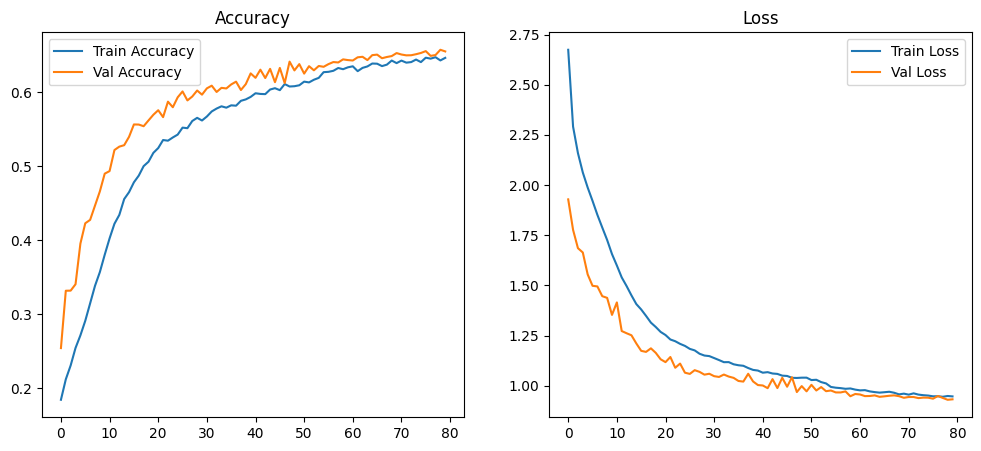

In [28]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


# Save the Model::

In [19]:
model.save("emotion_model.keras")

# Real-Time Emotion Detection (Local System)

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("best_emotion_model.h5")

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48,48))
        roi = roi / 255.0
        roi = roi.reshape(1,48,48,1)

        prediction = model.predict(roi)
        label = emotion_labels[np.argmax(prediction)]

        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        cv2.putText(frame,label,(x,y-10),
                    cv2.FONT_HERSHEY_SIMPLEX,0.9,(0,255,0),2)

    cv2.imshow("Emotion Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


2026-02-10 22:31:46.968325: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-10 22:31:46.980576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770742906.994264   42186 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770742906.998676   42186 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770742907.009357   42186 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is not the object's thread (0x2595c9d0).
Cannot move to target thread (0x24bf29d0)

QObject::moveToThread: Current thread (0x24bf29d0) is n

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
